# Модель оттока для прогнозирования ухода сотрудников

### Краткое описание

Ниже будет обучена модель для прогнозирования вероятности увольнения сотрудников. 
Данные искуственно сгенерированы датасаентистами IBM, но этот ноутбук можно использовать как готовый пайплайн для обучения модели на реальных данных, о которых мы расскажем в решение Кейса.

### Предпосылки

Текучесть кадров является дорогостоящей проблемой для компаний. 
По нашим расчетам, стоимость замены специалиста обойдется в 286.5 тыс. рублей и 12 недель, а стоимость замены рабочего в 137 тыс. рублей и 10 недель, что в 4 и 3 раза больше их месячной зарплаты соответственно

Команда John Galt предлагает прогнозировать уход сотрудников и, в зависимости от категории риска сотрудника, планировать его замену или меры удержания, так как зачастую меры удержания обходятся гораздо дешевле, чем поиск нового сотрудника.

### Библиотеки

In [1]:
# importing libraries for data handling and analysis
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas import ExcelWriter
from pandas import ExcelFile
from openpyxl import load_workbook
import numpy as np
from scipy.stats import norm, skew
from scipy import stats
import statsmodels.api as sm

In [2]:
# importing libraries for data visualisations
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib
%matplotlib inline
color = sns.color_palette()
from IPython.display import display
pd.options.display.max_columns = None
# Standard plotly imports
import plotly
#import plotly.plotly as py
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [3]:
# sklearn modules for preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# from imblearn.over_sampling import SMOTE  # SMOTE
# sklearn modules for ML model selection
from sklearn.model_selection import train_test_split  # import 'train_test_split'
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Libraries for data modelling
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Common sklearn Model Helpers
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
# from sklearn.datasets import make_classification

# sklearn modules for performance metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import average_precision_score

In [4]:
# importing misceallenous libraries
import os
import re
import sys
import timeit
import string
from datetime import datetime
from time import time
from dateutil.parser import parse
# ip = get_ipython()
# ip.register_magics(jupyternotify.JupyterNotifyMagics)

### Данные

> Это искусственные данные, сгенерированные датасаентистами IBM. Они предназначены для демонстрации возможностей IBM Watson Analytics в отношении увольнения сотрудников

In [5]:
# Read Excel file
df_sourcefile = pd.read_excel(
    'Data/WA_Fn-UseC_-HR-Employee-Attrition.xlsx', sheet_name=0)
print("Shape of dataframe is: {}".format(df_sourcefile.shape))

Shape of dataframe is: (1470, 35)


In [6]:
# Make a copy of the original sourcefile
df_HR = df_sourcefile.copy()

### Обзор данных

In [7]:
# Dataset columns
df_HR.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [8]:
# Dataset header
df_HR.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


> Набор данных содержит несколько числовых и категориальных столбцов, содержащих различную информацию о личных данных сотрудника и его трудоустройстве. Целевой переменной для предсказания будет являться показатель Усталости (Attrition)

In [9]:
df_HR.columns.to_series().groupby(df_HR.dtypes).groups

{int64: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager'], object: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']}

In [10]:
# Columns datatypes and missign values
df_HR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

> Предоставленные данные не содержат пропущенных значений. В HR-аналитике данные о сотрудниках вряд ли будут содержать большое количество пропущенных значений, поскольку отделы кадров обычно хранят все личные данные и данные о занятости в файле

### Корреляции


In [11]:
# Find correlations with the target and sort
df_HR_trans = df_HR.copy()
df_HR_trans['Target'] = df_HR_trans['Attrition'].apply(
    lambda x: 0 if x == 'No' else 1)
df_HR_trans = df_HR_trans.drop(
    ['Attrition', 'EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'], axis=1)
correlations = df_HR_trans.corr()['Target'].sort_values()
print('Most Positive Correlations: \n', correlations.tail(5))
print('\nMost Negative Correlations: \n', correlations.head(5))

Most Positive Correlations: 
 PerformanceRating     0.002889
MonthlyRate           0.015170
NumCompaniesWorked    0.043494
DistanceFromHome      0.077924
Target                1.000000
Name: Target, dtype: float64

Most Negative Correlations: 
 TotalWorkingYears    -0.171063
JobLevel             -0.169105
YearsInCurrentRole   -0.160545
MonthlyIncome        -0.159840
Age                  -0.159205
Name: Target, dtype: float64


C:\Users\HUAWEI\AppData\Local\Temp/ipykernel_16892/4110551566.py:7: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



> Тепловая карта для отображения корреляций

C:\Users\HUAWEI\AppData\Local\Temp/ipykernel_16892/401974661.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<AxesSubplot:>

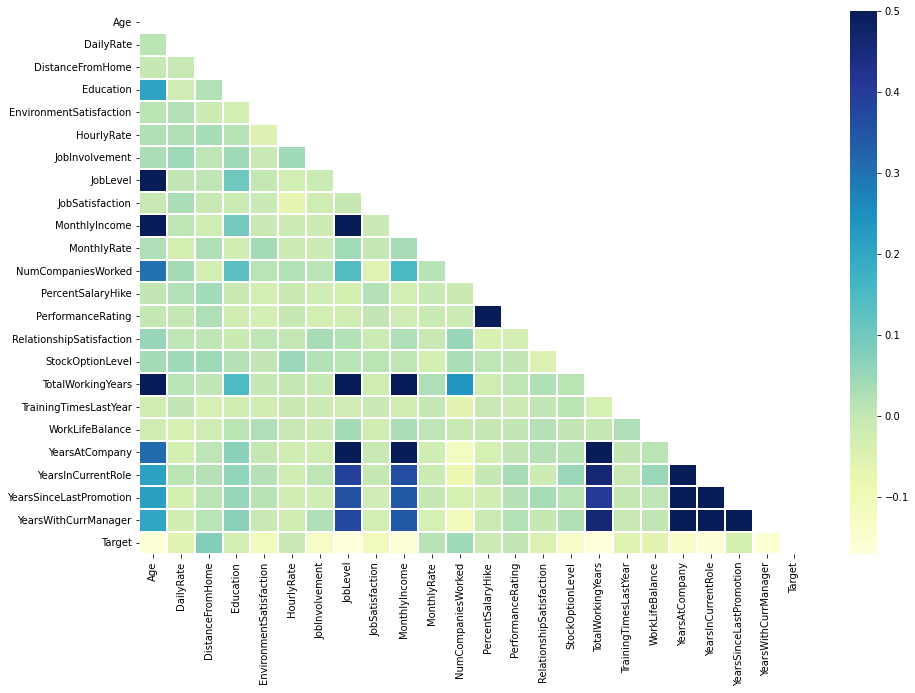

In [12]:
# Calculate correlations
corr = df_HR_trans.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr,
            vmax=.5,
            mask=mask,
            # annot=True, fmt='.2f',
            linewidths=.2, cmap="YlGnBu")

> Как показано выше, "Месячная ставка", "Количество работающих компаний" и "Расстояние от дома" положительно коррелируют с целевой переменной Усталости;
в то время как "Общее количество лет работы", "Уровень работы" и "Годы в текущей должности" отрицательно коррелируют с Усталостью.

### Encoding

In [13]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Create a label encoder object
le = LabelEncoder()

In [14]:
print(df_HR.shape)
df_HR.head()

(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [15]:
# Label Encoding will be used for columns with 2 or less unique values
le_count = 0
for col in df_HR.columns[1:]:
    if df_HR[col].dtype == 'object':
        if len(list(df_HR[col].unique())) <= 2:
            le.fit(df_HR[col])
            df_HR[col] = le.transform(df_HR[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

4 columns were label encoded.


In [16]:
# convert rest of categorical variable into dummy
df_HR = pd.get_dummies(df_HR, drop_first=True)

> Результирующий фрейм данных содержит **49 столбцов** для 1470 сотрудников.

In [17]:
print(df_HR.shape)
df_HR.head()

(1470, 49)


,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,1,1,2,0,94,3,2,4,5993,19479,8,0,1,11,3,1,80,0,8,0,1,6,4,0,5,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,49,0,279,8,1,1,2,3,1,61,2,2,2,5130,24907,1,0,0,23,4,4,80,1,10,3,3,10,7,1,7,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,37,1,1373,2,2,1,4,4,1,92,2,1,3,2090,2396,6,0,1,15,3,2,80,0,7,3,3,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,1,5,4,0,56,3,1,3,2909,23159,1,0,1,11,3,3,80,0,8,3,3,8,7,3,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,27,0,591,2,1,1,7,1,1,40,3,1,2,3468,16632,9,0,0,12,3,4,80,1,6,3,3,2,2,2,2,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0


### Scaling

In [18]:
# import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 5))
HR_col = list(df_HR.columns)
HR_col.remove('Attrition')
for col in HR_col:
    df_HR[col] = df_HR[col].astype(float)
    df_HR[[col]] = scaler.fit_transform(df_HR[[col]])
df_HR['Attrition'] = pd.to_numeric(df_HR['Attrition'], downcast='float')
df_HR.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,2.738095,1.0,3.579098,0.000000,1.25,0.0,0.000000,1.666667,0.0,4.571429,3.333333,1.25,5.000000,1.312270,3.490263,4.444444,0.0,5.0,0.000000,0.0,0.000000,0.0,0.000000,1.000,0.0,0.000000,0.75,1.111111,0.000000,1.470588,0.0,5.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0
1,3.690476,0.0,0.633500,1.250000,0.00,0.0,0.002419,3.333333,5.0,2.214286,1.666667,1.25,1.666667,1.085045,4.580004,0.555556,0.0,0.0,4.285714,5.0,5.000000,0.0,1.666667,1.250,2.5,3.333333,1.25,1.944444,0.333333,2.058824,5.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0
2,2.261905,1.0,4.549034,0.178571,1.25,0.0,0.007257,5.000000,5.0,4.428571,1.666667,0.00,3.333333,0.284623,0.060630,3.333333,0.0,5.0,1.428571,0.0,1.666667,0.0,0.000000,0.875,2.5,3.333333,0.00,0.000000,0.000000,0.000000,0.0,5.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,1.785714,0.0,4.617037,0.357143,3.75,0.0,0.009676,5.000000,0.0,1.857143,3.333333,0.00,3.333333,0.500263,4.229070,0.555556,0.0,5.0,0.000000,0.0,3.333333,0.0,0.000000,1.000,2.5,3.333333,1.00,1.944444,1.000000,0.000000,5.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0
4,1.071429,0.0,1.750179,0.178571,0.00,0.0,0.014514,0.000000,5.0,0.714286,3.333333,0.00,1.666667,0.647446,2.918691,5.000000,0.0,0.0,0.357143,0.0,5.000000,0.0,1.666667,0.750,2.5,3.333333,0.25,0.555556,0.666667,0.588235,0.0,5.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0


In [19]:
print('Size of Full Encoded Dataset: {}'. format(df_HR.shape))

Size of Full Encoded Dataset: (1470, 49)


### Разделение на test и training датасеты

75% данных будут использованы для обучения, в целом можно попробовать кросс-валидацию

In [20]:
# assign the target to a new dataframe and convert it to a numerical feature
#df_target = df_HR[['Attrition']].copy()
target = df_HR['Attrition'].copy()

In [21]:
type(target)

pandas.core.series.Series

In [22]:
# let's remove the target feature and redundant features from the dataset
df_HR.drop(['Attrition', 'EmployeeCount', 'EmployeeNumber',
            'StandardHours', 'Over18'], axis=1, inplace=True)
print('Size of Full dataset is: {}'.format(df_HR.shape))

Size of Full dataset is: (1470, 44)


In [23]:
# Since we have class imbalance (i.e. more employees with turnover=0 than turnover=1)
# let's use stratify=y to maintain the same ratio as in the training dataset when splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(df_HR,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=7,
                                                    stratify=target)  
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (1102, 44)
Number transactions y_train dataset:  (1102,)
Number transactions X_test dataset:  (368, 44)
Number transactions y_test dataset:  (368,)


## ML-модели

### Baseline Algorithms

> Воспользуемся рядом базовых алгоритмов (с использованием готовых гиперпараметров), прежде чем переходить к более сложным решениям. 
В этом разделе рассматриваются следующие алгоритмы: **Logistic Regression**, **Random Forest**, **SVM**, **KNN**, **Decision Tree Classifier**, **Gaussian NB**.

In [24]:
# selection of algorithms to consider and set performance measure
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state=7,
                                                         class_weight='balanced')))
models.append(('Random Forest', RandomForestClassifier(
    n_estimators=100, random_state=7)))
models.append(('SVM', SVC(gamma='auto', random_state=7)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree Classifier',
               DecisionTreeClassifier(random_state=7)))
models.append(('Gaussian NB', GaussianNB()))

In [25]:
acc_results = []
auc_results = []
names = []
# set table to table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD']
df_results = pd.DataFrame(columns=col)
i = 0
# evaluate each model using cross-validation
for name, model in models:
    kfold = model_selection.KFold(
        n_splits=10, shuffle=True, random_state=7)  # 10-fold cross-validation

    cv_acc_results = model_selection.cross_val_score(  # accuracy scoring
        model, X_train, y_train, cv=kfold, scoring='accuracy')

    cv_auc_results = model_selection.cross_val_score(  # roc_auc scoring
        model, X_train, y_train, cv=kfold, scoring='roc_auc')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)
                         ]
    i += 1
df_results.sort_values(by=['ROC AUC Mean'], ascending=False)

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
0,Logistic Regression,81.64,6.43,76.51,4.36
1,Random Forest,80.03,5.55,85.12,2.86
2,SVM,77.63,5.71,84.30,2.66
5,Gaussian NB,75.11,5.02,66.33,4.99
3,KNN,66.22,5.32,84.67,2.33
4,Decision Tree Classifier,65.37,6.30,80.31,4.05


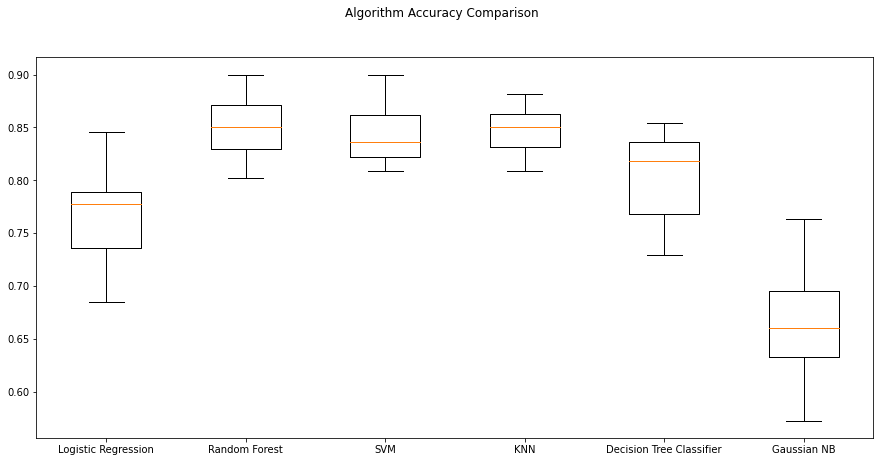

In [26]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Algorithm Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(acc_results)
ax.set_xticklabels(names)
plt.show()

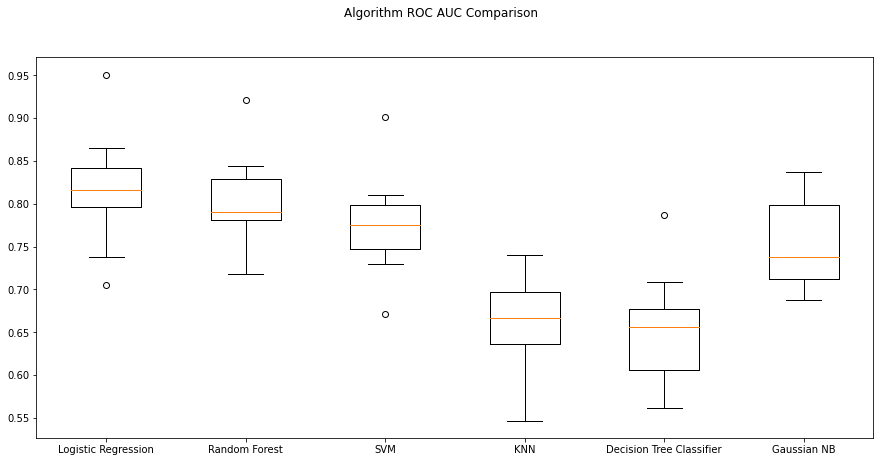

In [27]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Algorithm ROC AUC Comparison')
ax = fig.add_subplot(111)
plt.boxplot(auc_results)
ax.set_xticklabels(names)
plt.show()

> **Logistic Regression** и **Random Forest** показывают самые высокие средние показатели AUC

### Дополнительно я пробовал обучать градиентный бустинг, но он показывает худшие результаты, чем логистическая регрессия, ситуаций, когда он предсказывает что человек не хочет уволиться, а на самом деле человек хочет уволиться гораздо больше

### Logistic Regression

> Как основное решение обучим эту модель, будем использовать 10-кратную кросс-валидацию

In [28]:
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=7) 
modelCV = LogisticRegression(solver='liblinear',
                             class_weight="balanced", 
                             random_state=7)
scoring = 'roc_auc'
results = model_selection.cross_val_score(
    modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("AUC score (STD): %.2f (%.2f)" % (results.mean(), results.std()))

AUC score (STD): 0.82 (0.06)


#### Fine-tuning

In [32]:
param_grid = {'C': np.arange(1e-03, 2, 0.01)} # hyper-parameter list to fine-tune
log_gs = GridSearchCV(LogisticRegression(solver='liblinear', # setting GridSearchCV
                                         class_weight="balanced", 
                                         random_state=7),
                      return_train_score=True,
                      param_grid=param_grid,
                      scoring='roc_auc',
                      cv=10)

log_grid = log_gs.fit(X_train, y_train)
log_opt = log_grid.best_estimator_
results = log_gs.cv_results_

print('='*20)
print("best params: " + str(log_gs.best_estimator_))
print("best params: " + str(log_gs.best_params_))
print('best score:', log_gs.best_score_)
print('='*20)

best params: LogisticRegression(C=0.10099999999999998, class_weight='balanced',
                   random_state=7, solver='liblinear')
best params: {'C': 0.10099999999999998}
best score: 0.8154962538233308


#### Evaluation

Text(0.5, 257.44, 'Predicted label')

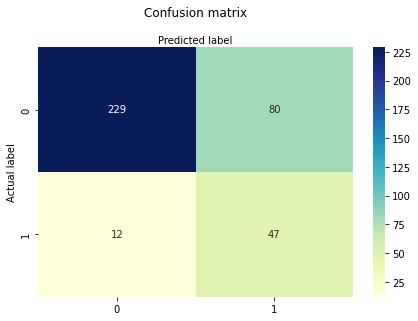

In [38]:
## Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, log_opt.predict(X_test))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [39]:
print('Accuracy of Logistic Regression Classifier on test set: {:.2f}'.format(log_opt.score(X_test, y_test)*100))

Accuracy of Logistic Regression Classifier on test set: 75.00


In [40]:
# Classification report for the optimised Log Regression
log_opt.fit(X_train, y_train)
print(classification_report(y_test, log_opt.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.95      0.74      0.83       309
         1.0       0.37      0.80      0.51        59

    accuracy                           0.75       368
   macro avg       0.66      0.77      0.67       368
weighted avg       0.86      0.75      0.78       368



> Выходные данные содержат первый индекс, относящийся к вероятности того, что данные принадлежат **классу 0** (сотрудник не уходит), а второй относится к вероятности того, что данные принадлежат **классу 1** (сотрудник уходит).

> Результирующий показатель AUC равен: 0,857, что выше, чем наилучший показатель на этапе оптимизации.

In [43]:
log_opt.fit(X_train, y_train) # fit optimised model to the training data
probs = log_opt.predict_proba(X_test) # predict probabilities
probs = probs[:, 1] # we will only keep probabilities associated with the employee leaving
logit_roc_auc = roc_auc_score(y_test, probs) # calculate AUC score using test dataset
print('AUC score: %.3f' % logit_roc_auc)

AUC score: 0.857


## Демонстрация работы алгоритма

In [104]:
# Предсказываем значения для X_test
y_pred = log_opt.predict(X_test)
y_proba = log_opt.predict_proba(X_test)

# Добавляем колонку 'Attrition' в начало DataFrame и записываем туда предсказанные значения
X = X_test
X.insert(0, 'Attrition', y_proba[:, 0])
# Выводим обновленный DataFrame
print(X)

      Attrition       Age  DailyRate  DistanceFromHome  Education  \
681    0.977510  2.380952   4.405870          0.000000       2.50   
946    0.076317  2.619048   0.705082          4.285714       3.75   
626    0.884941  1.666667   1.918397          1.250000       1.25   
1154   0.982165  3.452381   3.843951          4.464286       3.75   
669    0.142082  2.500000   3.650680          0.892857       2.50   
...         ...       ...        ...               ...        ...   
952    0.057880  1.547619   3.428776          0.000000       2.50   
165    0.965813  3.809524   4.831782          1.785714       2.50   
270    0.781455  4.404762   1.252684          0.000000       2.50   
7      0.676093  1.428571   4.495347          4.107143       0.00   
1231   0.910334  3.333333   2.201145          2.142857       3.75   

      EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel  \
681                  5.000000     0.0    3.571429        3.333333      2.50   
946          

**Сохраняем значения в файл Test_Data**

In [106]:
# Укажите путь к файлу Excel (XLSX)
excel_file_path = r'Test_Data_1.xlsx'

# Сохраните DataFrame в Excel
X.to_excel(excel_file_path, index=False, sheet_name='Лист1')

## Заключение

По мере того как компания генерирует больше данных о своих сотрудниках, модель может быть переобучена с использованием дополнительных данных и теоретически генерировать более точные прогнозы для выявления сотрудников с высоким риском увольнения на основе вероятностной метки, присвоенной каждой характеристической переменной (т.е. сотруднику) по алгоритму.

Работникам может быть присвоена категория риска на основании вероятности их увольнения:
- **Без опасений** для работников с вероятностью p < 0.5
- **Тревожные** для работников с вероятностью 0.5 <= p < 0.8
- **Склонные к увольнению** для работников с вероятностью 0.8 <= p <0.9
- **Наиболее склонные к увольнению** для работников с вероятностью p >= 0.9 <br>

Для каждой группы **Категории риска** мы предлагаем стратегический **"План удержания"**. Для сотрудников **Склонных** и **Наиболее склонных** к увольнению мы рекомендуем организовывать личные встречи с представителем отдела кадров или руководителем для обсуждения условий труда и выявления точек роста в рабочей среде.

### Дополнение

###### Можно выделить наиболее сильные показатели при уходе
- **Ежемесячный доход**: люди с более высокой заработной платой с меньшей вероятностью покинут компанию. Следовательно, следует приложить усилия для сбора информации о отраслевых показателях на текущем местном рынке, чтобы определить, обеспечивает ли компания конкурентоспособную заработную плату.
- **Сверхурочное время работы**: люди, работающие сверхурочно, с большей вероятностью покинут компанию. Следовательно, необходимо предпринять усилия для надлежащего планирования проектов заранее, с надлежащей поддержкой и рабочей силой, чтобы сократить использование сверхурочных.
- **Возраст**: Сотрудники в относительно молодой возрастной группе 25-35 лет с большей вероятностью уйдут. Следовательно, следует приложить усилия, чтобы четко сформулировать долгосрочное видение компании и чтобы молодые сотрудники соответствовали этому видению, а также обеспечить стимулы, например, в виде четких путей продвижения по службе.
- **Удаленность от дома**: Сотрудники, которые живут дальше от дома, с большей вероятностью покинут компанию.
- **Общий стаж работы**: У более опытных сотрудников меньше шансов уволиться. Сотрудники с опытом работы от 5 до 8 лет должны быть определены как потенциально подверженные более высокому риску увольнения.
- **YearsAtCompany**: Сотрудники, которые работают в компании меньше двух лет, должны быть определены как потенциально подверженные более высокому риску ухода.

###### В будущем можно отслеживать эмоциональное состояние некоторых категорий сотрудников с использованием технологий компьютерного зрения, но такое решение будет слишком дорогим для MVP